#Data process

In [46]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import (LinearRegression, Ridge,Lasso)
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation,metrics
label_val={'Bufonidae':0,'Dendrobatidae':1,'Hylidae':2,'Leptodactylidae':3,
     'Adenomera':0,'Ameerega':1,'Dendropsophus':2,'Hypsiboas':3,'Leptodactylus':4,'Osteocephalus':5,'Rhinella':6,'Scinax':7,
     'AdenomeraAndre':0,'AdenomeraHylaedactylus':1,'Ameeregatrivittata':2,'HylaMinuta':3,'HypsiboasCinerascens':4,'HypsiboasCordobae':5,'LeptodactylusFuscus':6,'OsteocephalusOophagus':7,'Rhinellagranulosa':8,'ScinaxRuber':9}
def data_process(path):
    raw_data=[]
    raw_label=[]
    raw_label_tran=[]
    with open(path, encoding='utf8') as file:
        file.readline()
        for line in file:
            data=[]
            for item in line.strip().split(','):
                data.append(item)
            raw_data.append([float(item) for item in data[:-4]])
            raw_label.append([item for item in data[-4:-1]])
            raw_label_tran.append([label_val[item] for item in data[-4:-1]])
    return raw_data,raw_label,raw_label_tran
data,label,label_tran=data_process('./data.csv')
print('Data process done')

Data process done


# 2.a k-means

The best param of dict_silhouette_new is 4


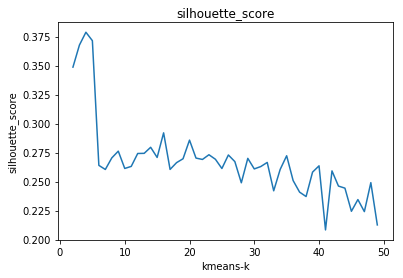

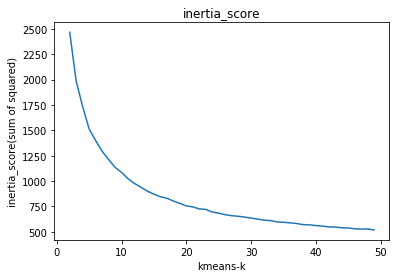

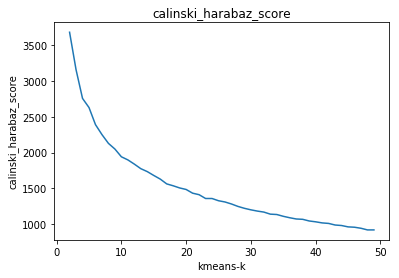

In [38]:
from sklearn.cluster import KMeans
def get_param(matrix):
    i = []
    y_silhouette_score = []
    inertia_score = []
    calinskiharabaz_score = []
    for k in range(2,50):
        kmeans_model = KMeans(n_clusters = k,init='k-means++')
        pred = kmeans_model.fit_predict(matrix)
        silhouettescore = metrics.silhouette_score(matrix, pred)
        #print ("silhouette_score for cluster '{}'".format(k))
        #print (silhouettescore)
        calinskiharabazscore =  metrics.calinski_harabaz_score(matrix, pred) 
        #print ("calinski_harabaz_score '{}'".format(k))
        #print (calinskiharabazscore)
        i.append( k )
        y_silhouette_score.append(silhouettescore )
        inertia_score.append(kmeans_model.inertia_)
        calinskiharabaz_score.append( calinskiharabazscore )
        #print ("kmeans_model.inertia_score for cluster '{}'".format(k))
        #print (kmeans_model.inertia_)

    dict_silhouette = dict(zip( i,y_silhouette_score))
    dict_inertia_score = dict(zip( i,inertia_score))
    dict_calinskiharabaz_score = dict(zip( i, calinskiharabaz_score))

    plt.figure()  
    plt.plot(i,y_silhouette_score)  
    plt.xlabel("kmeans-k")  
    plt.ylabel("silhouette_score")  
    plt.title("silhouette_score")  

    plt.figure()  
    plt.plot(i,inertia_score)  
    plt.xlabel("kmeans-k")  
    plt.ylabel("inertia_score(sum of squared)")  
    plt.title("inertia_score")  

    plt.figure()  
    plt.plot(i,calinskiharabaz_score)  
    plt.xlabel("kmeans-k")  
    plt.ylabel("calinski_harabaz_score")  
    plt.title("calinski_harabaz_score")  
    dict_silhouette_new=sorted(dict_silhouette.items(),key=lambda x:x[1],reverse=True)
    k=dict_silhouette_new[0][0]
    print('The best param of dict_silhouette_new is',k)
    return k
k=get_param(data)

In this part, I use calinski_harabaz_score,silhouette_score and inertia_score to choose K. Besides, I have plotted the score of dofferent K between 2 and 50. When we use silhouette_score, the number of 4 has the best perfomance. However, when we use calinski_harabaz_score, the number of 2 is the best. In the end, we choose silhouette_score as the parameter in the work!

# 2.b The majority label

In [48]:
from collections import Counter
km_cluster = KMeans(n_clusters=k, max_iter=500, init='k-means++', n_jobs=-1)
result = km_cluster.fit_predict(data)
cluster={}
for i in range(len(result)):
    cluster[i]=result[i]
cluster_out=[]
for k_tmp in range(k):
    fam=[]
    gen=[]
    spe=[]
    for i in range(len(result)):
        if k_tmp==result[i]:
            fam.append(label[i][0])
            gen.append(label[i][1])
            spe.append(label[i][2])
    #print(Counter(fam))
    #print(Counter(gen))
    #print(Counter(spe))
    cluster_out.append([Counter(fam).most_common(1)[0][0],Counter(gen).most_common(1)[0][0],Counter(spe).most_common(1)[0][0]])
    print('In clust {}, the majority family is {},the majority genus is {} and the majority species is {}'.format(k_tmp,Counter(fam).most_common(1)[0][0],Counter(gen).most_common(1)[0][0],Counter(spe).most_common(1)[0][0]))

In clust 0, the majority family is Leptodactylidae,the majority genus is Adenomera and the majority species is AdenomeraAndre
In clust 1, the majority family is Hylidae,the majority genus is Hypsiboas and the majority species is HypsiboasCordobae
In clust 2, the majority family is Leptodactylidae,the majority genus is Adenomera and the majority species is AdenomeraHylaedactylus
In clust 3, the majority family is Hylidae,the majority genus is Hypsiboas and the majority species is HypsiboasCordobae


# 2.c Calculate Hamming score

In [76]:
# Hamming Loss
from sklearn.metrics import hamming_loss
def hammingDistance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))
def hamming(y_true,y_pred):
    #print('hamming_loss is :',hamming_loss(y_true, y_pred))
    return hamming_loss(y_true, y_pred)
for k_tmp in range(k):
    pred_label=[label_val[item] for item in cluster_out[k_tmp]]
    hamming_distance=[]
    hamming_loss_val=[]
    for i_clus in range(len(result)):
        if k_tmp==result[i_clus]:
            true_label=[label_val[item] for item in label[i_clus]]
            hamming_distance.append(hammingDistance(true_label,pred_label))
            hamming_loss_val.append(hamming(true_label,pred_label))
    dis=sum(hamming_distance)/len(hamming_distance)
    loss=sum(hamming_loss_val)/len(hamming_loss_val)
    print('In clust {}, the Hamming distance is {} and Hamming loss is {}'.format(k_tmp,dis,loss))

In clust 0, the Hamming distance is 1.145658263305322 and Hamming loss is 0.38188608776843996
In clust 1, the Hamming distance is 1.8625618471687742 and Hamming loss is 0.620853949056256
In clust 2, the Hamming distance is 0.07837078651685393 and Hamming loss is 0.02612359550561798
In clust 3, the Hamming distance is 0.7341197822141561 and Hamming loss is 0.24470659407138537


# 2 Appendix: Monte-Carlo Simulation

In [83]:
out={}
for iterator in range(50):
    y_silhouette_score = []
    i = []
    k=4
    km_cluster = KMeans(n_clusters=k, max_iter=500, init='k-means++', n_jobs=-1)
    result = km_cluster.fit_predict(data)
    cluster={}
    for i in range(len(result)):
        cluster[i]=result[i]
    cluster_out=[]
    for k_tmp in range(k):
        fam=[]
        gen=[]
        spe=[]
        for i in range(len(result)):
            if k_tmp==result[i]:
                fam.append(label[i][0])
                gen.append(label[i][1])
                spe.append(label[i][2])
        cluster_out.append([Counter(fam).most_common(1)[0][0],Counter(gen).most_common(1)[0][0],Counter(spe).most_common(1)[0][0]])
    for k_tmp in range(k):
        pred_label=[label_val[item] for item in cluster_out[k_tmp]]
        hamming_distance=[]
        hamming_loss_val=[]
        for i_clus in range(len(result)):
            if k_tmp==result[i_clus]:
                true_label=[label_val[item] for item in label[i_clus]]
                hamming_distance.append(hammingDistance(true_label,pred_label))
                hamming_loss_val.append(hamming(true_label,pred_label))
        dis=sum(hamming_distance)/len(hamming_distance)
        loss=sum(hamming_loss_val)/len(hamming_loss_val)
        if k_tmp not in out.keys():
            out[k_tmp]=[dis]
        else:
            out[k_tmp].append(dis)
for k_tmp in range(4):
    print('After 50 times, In clust {}, the mean Hamming distance is {} and std Hamming loss distance {}'.format(k_tmp,np.mean(out[k_tmp]),np.std(out[k_tmp])))

After 50 times, In clust 0, the mean Hamming distance is 0.6465448561309369 and std Hamming loss distance 0.6395044473650933
After 50 times, In clust 1, the mean Hamming distance is 0.7711644845293796 and std Hamming loss distance 0.6618580790380972
After 50 times, In clust 2, the mean Hamming distance is 0.8991376090344023 and std Hamming loss distance 0.5294129944938244
After 50 times, In clust 3, the mean Hamming distance is 1.1026053237358537 and std Hamming loss distance 0.5137152989807455


As you can see from the distance above, when we just do the experiment one time, the cluster has the best perfomence comparing with the others, which has the lowest loss(0.026). However, when we repeat 50 times, the Hamming distance and loss is similiar, which means the consult has better robustness.